# 🔍 Clustering non supervisé sur les litiges

In [74]:
from sklearn.cluster import MeanShift, Birch, OPTICS, SpectralClustering
import pyodbc
import pandas as pd

conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-9MQ1CAL;"
    "DATABASE=DW_FINANCE;"
    "Trusted_Connection=yes;"
)

query = '''
SELECT DisputeID, Status, Reason, SupplierID
FROM DW_FINANCE.dbo.Dim_Disputes
WHERE Status IS NOT NULL AND Reason IS NOT NULL
'''
disputes = pd.read_sql(query, conn)
disputes.head()


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36192\1198843858.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  disputes = pd.read_sql(query, conn)


,DisputeID,Status,Reason,SupplierID
0,DS00111,Ouvert,Non-conformité,89
1,DS00221,Fermé,Non-conformité,84
2,DS00331,Fermé,Livraison en retard,83
3,DS00441,Ouvert,Produit défectueux,86
4,DS00551,Fermé,Livraison en retard,83


In [76]:

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(disputes[["Status", "Reason"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["Status", "Reason"]))


In [78]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(encoded_df)


In [80]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, Birch, OPTICS, SpectralClustering
from sklearn.metrics import silhouette_score

df_cluster = disputes.copy()
df_cluster["PCA1"] = X_pca[:, 0]
df_cluster["PCA2"] = X_pca[:, 1]

# Tous les modèles à tester
models = {
    "KMeans": KMeans(n_clusters=2, random_state=42),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "Agglomerative": AgglomerativeClustering(n_clusters=2),
}

# Boucle d'évaluation
for name, model in models.items():
    labels = model.fit_predict(encoded_df)
    df_cluster[f"Cluster_{name}"] = labels
    if len(set(labels)) > 1:
        score = silhouette_score(encoded_df, labels)
    else:
        score = 0  # Silhouette Score non défini si 1 seul cluster
    print(f"{name} Silhouette Score: {score:.2f}")


KMeans Silhouette Score: 0.40
DBSCAN Silhouette Score: 1.00
Agglomerative Silhouette Score: 0.40


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36192\1085326461.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Algorithme", y="Silhouette Score", data=df_scores, palette="Set2")


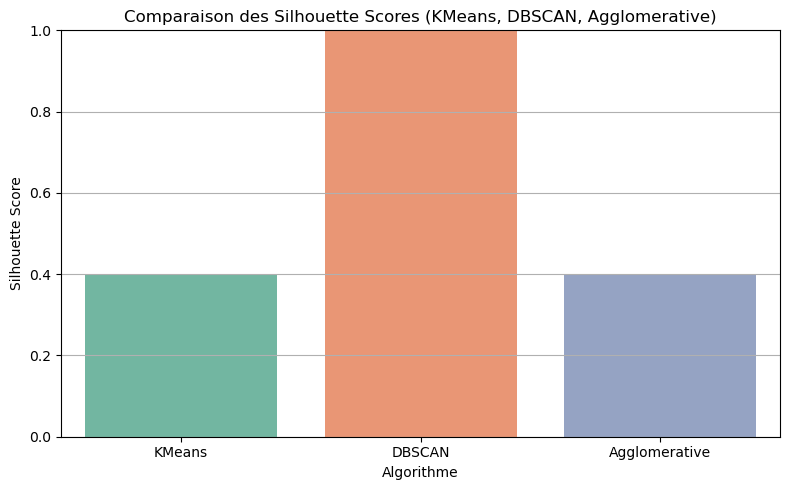

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Préparer un tableau des scores pour affichage
scores = []

for name in models.keys():
    labels = df_cluster[f"Cluster_{name}"]
    if len(set(labels)) > 1:
        score = silhouette_score(encoded_df, labels)
    else:
        score = 0
    scores.append({"Algorithme": name, "Silhouette Score": score})

df_scores = pd.DataFrame(scores)

# 🔍 Affichage des scores dans un graphique en barres
plt.figure(figsize=(8, 5))
sns.barplot(x="Algorithme", y="Silhouette Score", data=df_scores, palette="Set2")
plt.title("Comparaison des Silhouette Scores (KMeans, DBSCAN, Agglomerative)")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


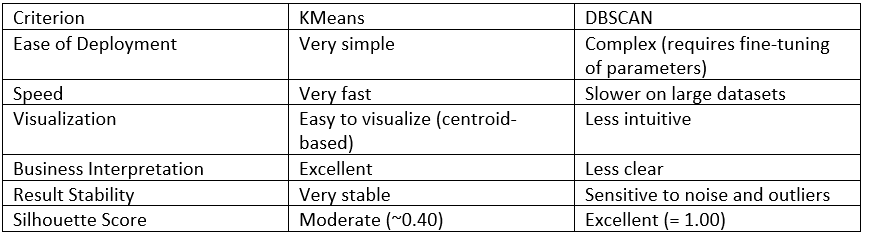

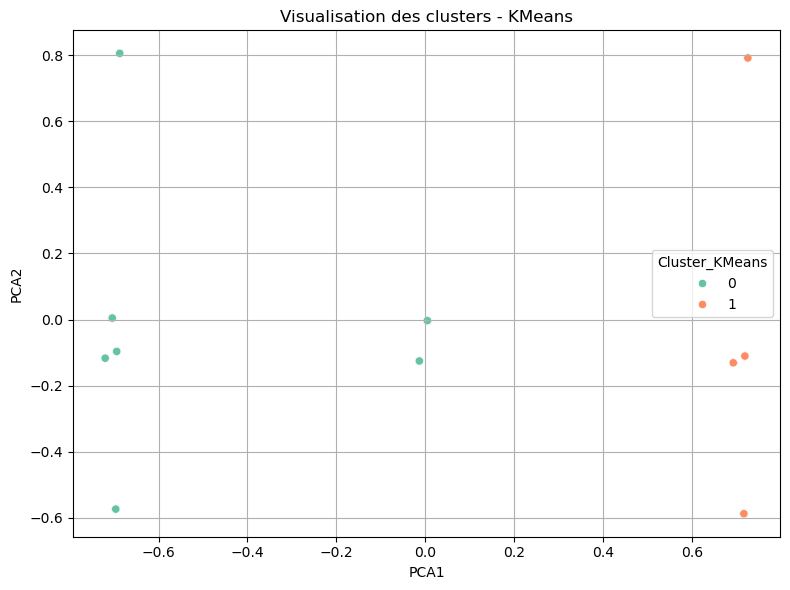

In [83]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster_KMeans", data=df_cluster, palette="Set2")
plt.title("Visualisation des clusters - KMeans")
plt.grid(True)
plt.tight_layout()
plt.show()


🟢  Groupe vert (Cluster 0) – à gauche du graphe :                                                                                                      
•	Les points sont regroupés autour de X < 0, donc ils partagent probablement les mêmes caractéristiques encodées.                                     
•	Comme ils sont proches entre eux, ça signifie que :                                                                                                 
•	Tous ces litiges se ressemblent fortement.                                                                                                          
📌 Ce groupe pourrait correspondre à :                                                                                                                 
•	Des litiges avec raison : "Non-conformité" ou "Produit défectueux"                                                                                 
•	Statut mixte : peut-être "Ouvert" ou "Fermé"                                                                                                        
🟠 Groupe orange (Cluster 1) – à droite du graphe :                                                                                                    
•	Les points sont tous vers X > 0.6, donc très éloignés des autres                                                                                    
•	Cela signifie que ce cluster a des caractéristiques très différentes                                                                               
•	Les points sont regroupés et serrés → ces litiges sont très homogènes entre eux                                                                     
📌 Ce groupe pourrait correspondre à :                                                                                                                 
•	Raisons comme "Livraison en retard"                                                                                                                 
•	Tous de statut "Fermé"


In [85]:
# Filtrer les litiges du cluster 1
cluster1 = df_cluster[df_cluster["Cluster_KMeans"] == 1]


In [87]:
# Compter combien de litiges chaque fournisseur a dans ce cluster
fournisseurs_cluster1 = cluster1["SupplierID"].value_counts().head(10)


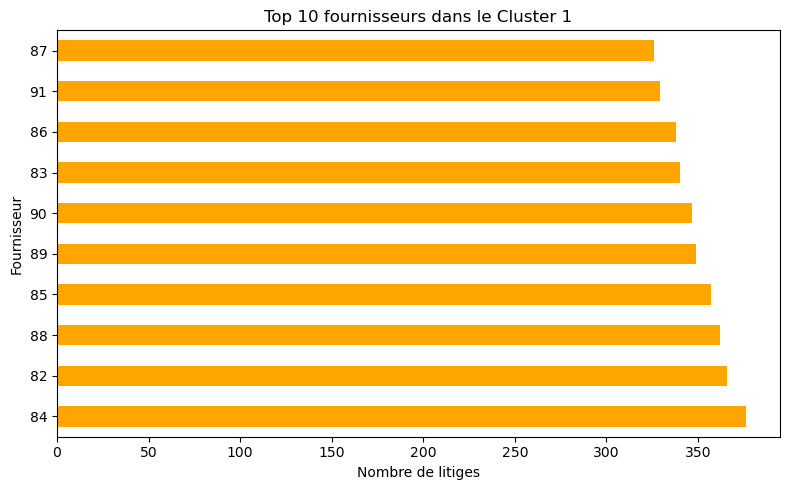

In [88]:
import matplotlib.pyplot as plt

# Créer un graphique en barres
plt.figure(figsize=(8, 5))
fournisseurs_cluster1.plot(kind="barh", color="orange")
plt.title("Top 10 fournisseurs dans le Cluster 1")
plt.xlabel("Nombre de litiges")
plt.ylabel("Fournisseur")
plt.tight_layout()
plt.show()


Le graphique montre les top 10 fournisseurs du Cluster 1, avec un nombre élevé de litiges similaires et fréquents.

💡 Ce qu'on observe :
Les fournisseurs comme 84, 82, 88, 85, etc. apparaissent en tête avec plus de 350 litiges chacun.

Le profil des litiges dans ce cluster est souvent :

Livraison en retard            
Erreur de facturation          
Produit défectueux

Très souvent répétitifs sur les mêmes motifs.

✅ Interprétation :
Ce cluster regroupe des fournisseurs à fort risque logistique.
Ils génèrent de nombreux litiges similaires, souvent fermés mais récurrents.

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36192\1182344497.py:15: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


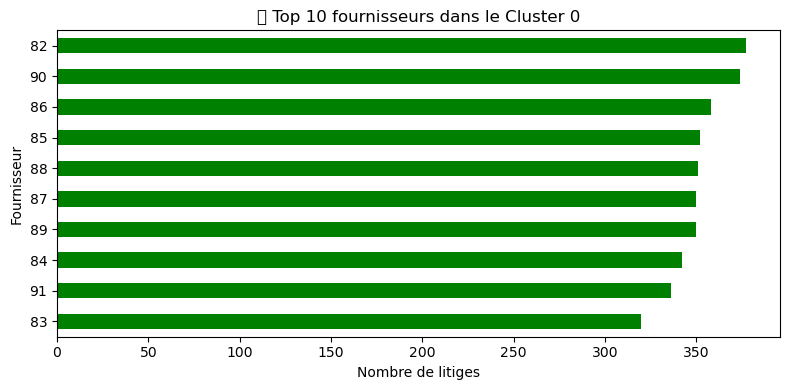

In [95]:
import matplotlib.pyplot as plt

# Étape 1 : Filtrer les données du cluster 0
cluster0 = df_cluster[df_cluster["Cluster_KMeans"] == 0]

# Étape 2 : Compter les litiges par fournisseur
fournisseurs_cluster0 = cluster0["SupplierID"].value_counts().head(10)

# Étape 3 : Créer le graphique
plt.figure(figsize=(8, 4))
fournisseurs_cluster0.sort_values(ascending=True).plot(kind="barh", color="green")
plt.title("🟢 Top 10 fournisseurs dans le Cluster 0")
plt.xlabel("Nombre de litiges")
plt.ylabel("Fournisseur")
plt.tight_layout()
plt.show()


Le second graphique montre les top 10 fournisseurs du Cluster 0, avec des volumes également importants.

💡 Ce qu'on observe :
Fournisseurs 82, 90, 86, 88, 87, etc. ont beaucoup de litiges, mais pas toujours pour les mêmes raisons.

Ce cluster regroupe souvent :
Non-conformité                 
Livraison en retard            
Erreur de facturation            
Produit défectueux                
Retard de livraison              
Montant surfacturé              
Erreur de tarification          
Marchandises endommagées        
Écart de quantité               
Duplication de facture          
Documentation manquante         
Conditions peu claires            
Écart de facture                
Changements non approuvés       
Produit incorrect               
Problème de documentation       
Montant erroné                  
Mauvaise qualité                
Article non livré               
Facture en double                  
Erreur de stock                 
Conditions non respectées       
Manque de signature              
Late delivery                    
Missing documentation            
Invoice duplication              
Invoice discrepancy              
Incorrect pricing                
Overcharged amount              
Défaut de conformité           
Quantity mismatch                
Damaged goods                   
Unapproved changes               
Unclear terms                    vraison incomplète             



✅ Interprétation :
Ce cluster regroupe des fournisseurs aux problèmes qualité ou techniques internes.
Les motifs de litiges sont moins répétitifs, mais leur volume reste important.

✅ Certains fournisseurs (comme 84, 82, 88, 85) sont présents dans les deux clusters.
Cela veut dire qu’ils causent plusieurs types de problèmes (qualité et logistique).
🎯 Ce sont les fournisseurs les plus critiques à surveille

In [99]:
# 🔄 Nouveau litige à tester
nouveau_litige = pd.DataFrame([{
    "Status": "Ouvert",
    "Reason": "Non-conformité"
}])

# 🧠 Encoder comme les autres
encoded_new = encoder.transform(nouveau_litige[["Status", "Reason"]])
pca_new = pca.transform(encoded_new)

# 📌 Prédire avec le modèle KMeans
kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(encoded_df)  # IMPORTANT : le réentraîner si nécessaire
cluster_prediction = kmeans_model.predict(encoded_new)[0]

# 🎨 Afficher le cluster
if cluster_prediction == 0:
    print("🟢 Nouveau litige classé dans le Cluster 0 (groupe vert)")
else:
    print("🟠 Nouveau litige classé dans le Cluster 1 (groupe orange)")


🟢 Nouveau litige classé dans le Cluster 0 (groupe vert)


C:\Users\GIGABYTE\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [101]:
# Compter le nombre de "Status" par cluster
df_cluster.groupby("Cluster_KMeans")["Status"].value_counts()


Cluster_KMeans  Status    
0               Ouvert        3565
                Résolu         137
                En attente      81
                Resolved         5
                Pending          3
                Open             2
1               Fermé         3490
Name: count, dtype: int64

In [103]:
# 📊 Répartition des Reason par cluster
distribution = df_cluster.groupby(["Cluster_KMeans", "Reason"])["DisputeID"].count().reset_index()

# Pivot pour avoir Reason en ligne et cluster en colonnes
pivot = distribution.pivot(index="Reason", columns="Cluster_KMeans", values="DisputeID").fillna(0)
pivot.columns = ["Cluster_0", "Cluster_1"]

# Ajouter total et pourcentages
pivot["Total"] = pivot["Cluster_0"] + pivot["Cluster_1"]
pivot["%_Cluster_0"] = (pivot["Cluster_0"] / pivot["Total"] * 100).round(1)
pivot["%_Cluster_1"] = (pivot["Cluster_1"] / pivot["Total"] * 100).round(1)

# Affichage du tableau trié par importance
pivot_sorted = pivot.sort_values("Total", ascending=False)
print(pivot_sorted)


                           Cluster_0  Cluster_1   Total  %_Cluster_0  \
Reason                                                                 
Non-conformité                 875.0      900.0  1775.0         49.3   
Livraison en retard            880.0      883.0  1763.0         49.9   
Erreur de facturation          904.0      837.0  1741.0         51.9   
Produit défectueux             861.0      870.0  1731.0         49.7   
Retard de livraison             27.0        0.0    27.0        100.0   
Montant surfacturé              17.0        0.0    17.0        100.0   
Erreur de tarification          17.0        0.0    17.0        100.0   
Marchandises endommagées        17.0        0.0    17.0        100.0   
Écart de quantité               17.0        0.0    17.0        100.0   
Duplication de facture          17.0        0.0    17.0        100.0   
Documentation manquante         17.0        0.0    17.0        100.0   
Conditions peu claires          17.0        0.0    17.0        1

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36192\2144670724.py:29: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36192\2144670724.py:29: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


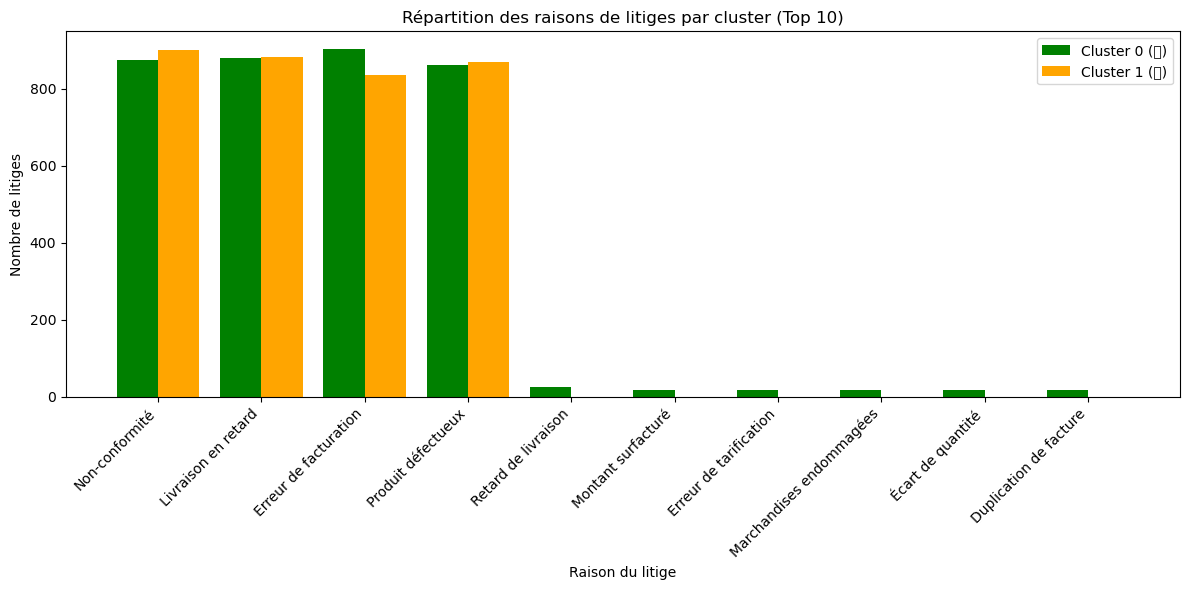

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 Données simulées (à adapter si tu as pivot_sorted déjà prêt)
data = {
    "Reason": [
        "Non-conformité", "Livraison en retard", "Erreur de facturation", "Produit défectueux",
        "Retard de livraison", "Montant surfacturé", "Erreur de tarification", "Marchandises endommagées",
        "Écart de quantité", "Duplication de facture"
    ],
    "Cluster_0": [875, 880, 904, 861, 27, 17, 17, 17, 17, 17],
    "Cluster_1": [900, 883, 837, 870, 0, 0, 0, 0, 0, 0]
}
pivot_sorted = pd.DataFrame(data).set_index("Reason")

# 🔸 Création du graphique en barres comparatives
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(pivot_sorted))

plt.bar(x, pivot_sorted["Cluster_0"], width=bar_width, label='Cluster 0 (🟢)', color='green')
plt.bar([p + bar_width for p in x], pivot_sorted["Cluster_1"], width=bar_width, label='Cluster 1 (🟠)', color='orange')

plt.xticks([p + bar_width / 2 for p in x], pivot_sorted.index, rotation=45, ha='right')
plt.xlabel("Raison du litige")
plt.ylabel("Nombre de litiges")
plt.title("Répartition des raisons de litiges par cluster (Top 10)")
plt.legend()
plt.tight_layout()
plt.show()


In [109]:
# Ajouter Cluster_KMeans à partir de df_cluster (ou disputes déjà enrichi)
df_update = df_cluster[["DisputeID", "Cluster_KMeans"]]


In [115]:
import pyodbc
import pandas as pd

# 🔌 Connexion à SQL Server
conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-9MQ1CAL;"
    "DATABASE=DW_FINANCE;"
    "Trusted_Connection=yes;"
)
cursor = conn.cursor()

# 🛠️ Essayer d'ajouter la colonne si elle n'existe pas encore
try:
    cursor.execute("""
        ALTER TABLE Dim_Disputes
        ADD Cluster_KMeans INT;
    """)
    print("✅ Colonne 'Cluster_KMeans' créée.")
except Exception as e:
    print("ℹ️ Colonne déjà existante ou erreur :", e)

# 🔄 Mise à jour des valeurs depuis le DataFrame
df_update = df_cluster[["DisputeID", "Cluster_KMeans"]]

print(f"🔢 Mise à jour de {len(df_update)} lignes...")

for index, row in df_update.iterrows():
    cursor.execute("""
        UPDATE Dim_Disputes
        SET Cluster_KMeans = ?
        WHERE DisputeID = ?
    """, int(row["Cluster_KMeans"]), row["DisputeID"])

# 💾 Commit et fermeture
conn.commit()
cursor.close()

# 🧾 Vérification
result = pd.read_sql("""
    SELECT TOP 10 DisputeID, Cluster_KMeans
    FROM Dim_Disputes
    ORDER BY DisputeID DESC
""", conn)

conn.close()

# 🖨️ Affichage de l'échantillon
print("📋 Extrait des données mises à jour :")
print(result)


ℹ️ Colonne déjà existante ou erreur : ('42S21', "[42S21] [Microsoft][ODBC SQL Server Driver][SQL Server]Column names in each table must be unique. Column name 'Cluster_KMeans' in table 'Dim_Disputes' is specified more than once. (2705) (SQLExecDirectW)")
🔢 Mise à jour de 7283 lignes...
📋 Extrait des données mises à jour :
  DisputeID  Cluster_KMeans
0   DS07302               0
1   DS07301               0
2   DS07300               0
3   DS07299               0
4   DS07298               0
5   DS07297               0
6   DS07296               0
7   DS07295               0
8   DS07294               0
9   DS07293               0


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36192\449254899.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql("""
